# Inference: Slice Sampling with Overrelaxation
This example shows you how to perform Bayesian inference on a Gaussian distribution and a time-series problem, using
Slice Sampling with Stepout and Overrelaxation.

Overrelaxed steps increase sampling efficiency in highly correlated
    unimodal distributions by suppressing the random walk behaviour of
    single-variable slice sampling: each variable is still updated in turn,
    but rather than drawing a new value for a variable from its conditional
    distribution independently of the current value, the new value is instead
    chosen to be on the opposite side of the mode from the current value. The
    interval ``I`` is still calculated via Stepout, and the edges ``l,r`` are
    used to estimate the slice endpoints via bisection. To obtain a full
    sampling scheme, overrelaxed updates are alternated with normal Stepout
    updates.

First, we create a simple normal distribution.

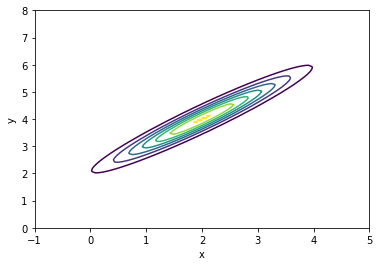

In [14]:
import os
os.chdir("../")
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.GaussianLogPDF([2, 4], [[1, 0.96], [0.96, 1]])

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-1, 5, num_points)
y = np.linspace(-0, 8, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Set MCMCController and Overrelaxation Parameter

The probability of pursuing an overrelaxed step, ``_prob_overrelaxed`` (0 as default), and the number of bisection iterations, ``a``, are hyperparameters. In [1], Neal suggests to set almost every update to being overrelaxed and to set a high number of interval expansion steps ``m``.

[1] Neal, R.M., 2003. Slice sampling. The annals of statistics, 31(3),
    pp.705-767.

In [15]:
# Choose starting point for 3 mcmc chains
xs = [
    [2, 4],
    [3, 3],
    [5, 4],
]

# Create mcmc routine
mcmc = pints.MCMCController(log_pdf, 3, xs, method=pints.SliceStepoutMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1000)

for sampler in mcmc.samplers():
    sampler.set_w([0.1, 0.1])
    sampler.set_m(100)
    sampler.set_prob_overrelaxed(0.95)
    sampler.set_a(10)
    
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Stepout
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     339     0:00.0
2     569     0:00.1
3     774     0:00.1
1000  184395   0:07.2
2000  367626   0:14.1
Halting: Maximum number of iterations (2000) reached.
Done!


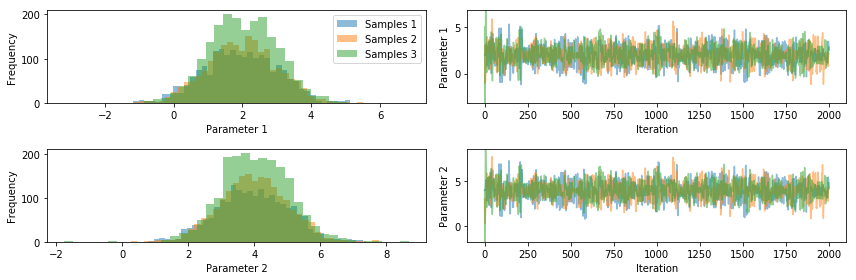

In [16]:
# Show traces and histograms
import pints.plot
pints.plot.trace(full_chains)
plt.show()

R-hat:
[1.000748123448914, 1.0006759435498647]
0.007523226906907876
0.00033719890056049806
0.00519077132395096


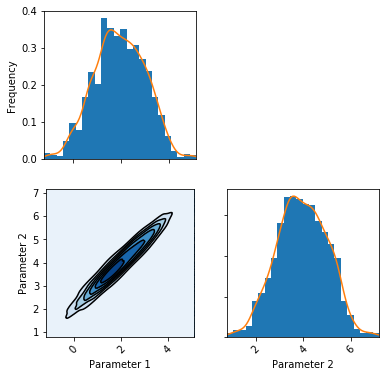

In [17]:
# Discard warm up
chains = full_chains[:, 200:]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Check Kullback-Leibler divergence of chains
print(log_pdf.kl_divergence(chains[0]))
print(log_pdf.kl_divergence(chains[1]))
print(log_pdf.kl_divergence(chains[2]))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)
plt.show()

# Slice Sampling with Doubling on a time-series problem
We now try the same method on a time-series problem

In [18]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise * 0.1],
    [0.02, 600, noise * 100],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
num_chains = 3
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Create mcmc routine
mcmc = pints.MCMCController(
    log_posterior, num_chains, xs, method=pints.SliceStepoutMCMC)

for sampler in mcmc.samplers():
    sampler.set_w(1)
    sampler.set_m(100)
    sampler.set_prob_overrelaxed(0.90)
    sampler.set_a(10)
    
# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1000)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Stepout
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     542     0:00.0
2     919     0:00.1
3     1306    0:00.1
1000  181123   0:14.8
2000  359328   0:29.6
Halting: Maximum number of iterations (2000) reached.
Done!


R-hat:
[1.0212851802411382, 1.0024204668800105, 0.999740888820444]


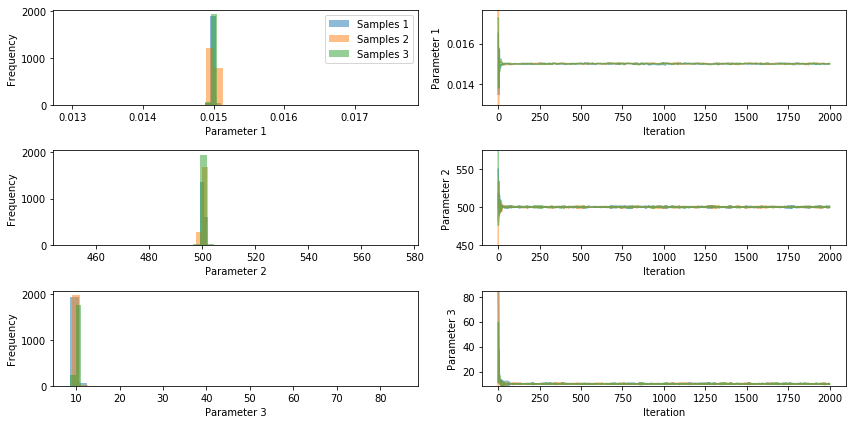

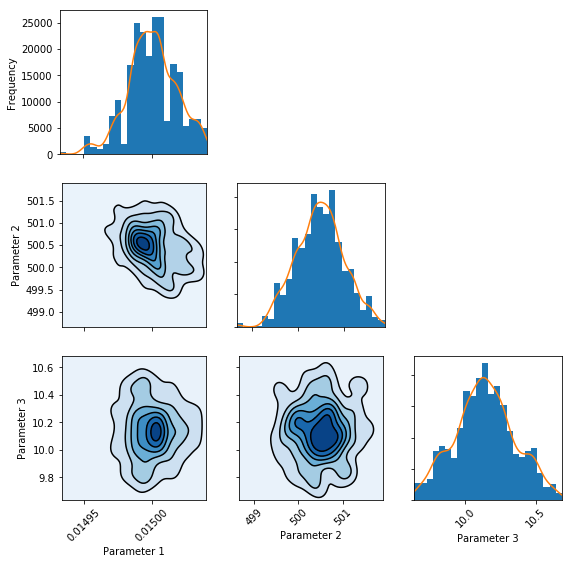

In [19]:
# Show traces and histograms
pints.plot.trace(full_chains)

# Discard warm up
full_chains = full_chains[:, 200:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(full_chains))

# Look at distribution in chain 0
pints.plot.pairwise(full_chains[0], kde=True)

# Show graphs
plt.show()

# Slice Sampling with Overrelaxation on a Multimodal Distribution

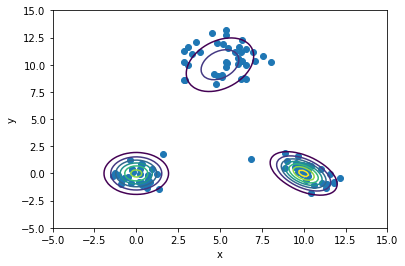

In [33]:
covariances = [[[1, 0], [0, 1]],
               [[2, 0.8], [0.8, 3]],
               [[1, -0.5], [-0.5, 1]]]
log_pdf = pints.toy.MultimodalGaussianLogPDF(modes=[[0, 0], [5, 10], [10, 0]], covariances=covariances)

samples = log_pdf.sample(100)

# Contour plot of pdf
num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.scatter(samples[:,0], samples[:,1])
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [35]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform([2, 2], [8, 8], size=(4, 2))
sigma0 = [1, 1]
mcmc = pints.MCMCController(log_pdf, 4, x0, method=pints.SliceStepoutMCMC, sigma0=sigma0)

for sampler in mcmc.samplers():
    sampler.set_w(1)
    sampler.set_m(50)
    sampler.set_prob_overrelaxed(0.90)
    sampler.set_a(10)

# Set maximum number of iterations
mcmc.set_max_iterations(2000)

# Disable logging
mcmc.set_log_to_screen(False)

# Number of chains
num_chains = 4

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Discard warm-up
chains = [chain[250:] for chain in chains]

Running...
Done!


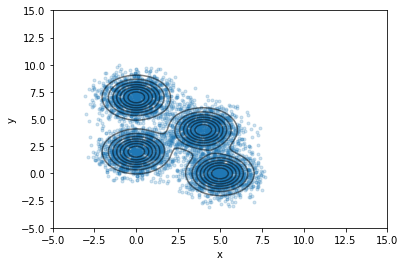

In [32]:
stacked = np.vstack(chains)
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [25]:
print("KL divergence by mode: " + str(log_pdf.kl_divergence(stacked)))

KL divergence by mode: [0.00072709 0.02518232 0.00174546]


# Slice Sampling with Doubling on a Multimodal Distribution - 2

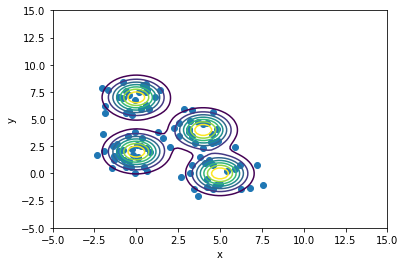

In [26]:
log_pdf = pints.toy.MultimodalGaussianLogPDF(modes=[[0, 2], [0, 7], [5, 0], [4, 4]])

samples = log_pdf.sample(100)

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.scatter(samples[:,0], samples[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [30]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform([2, 2], [8, 8], size=(4, 2))
mcmc = pints.MCMCController(log_pdf, 4, x0, method=pints.SliceStepoutMCMC)

for sampler in mcmc.samplers():
    sampler.set_w(2)
    sampler.set_m(10)
    sampler.set_prob_overrelaxed(0.95)
    sampler.set_a(10)

# Set maximum number of iterations
mcmc.set_max_iterations(2000)
mcmc.set_log_interval(1000)

# Disable logging
mcmc.set_log_to_screen(True)

# Number of chains
num_chains = 4

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Discard warm-up
chains = [chain[1000:] for chain in chains]

Running...
Using Slice Sampling - Stepout
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     4       0:00.0
1     177     0:00.0
2     377     0:00.1
3     582     0:00.1
1000  192744   0:20.6
2000  383879   0:41.2
Halting: Maximum number of iterations (2000) reached.
Done!


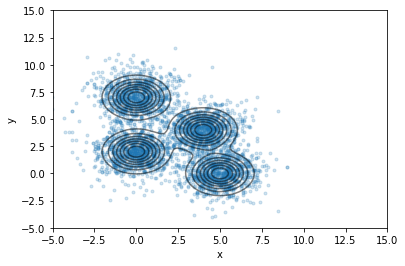

In [28]:
stacked = np.vstack(chains)
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [29]:
print("KL divergence by mode: " + str(log_pdf.kl_divergence(stacked)))

KL divergence by mode: [0.03507494 0.08136016 0.02911589 0.01076913]


# Slice Sampling with Doubling on a time-series problem - 2

In [38]:
model = pints.toy.LotkaVolterraModel()

print('Outputs: ' + str(model.n_outputs()))
print('Parameters: ' + str(model.n_parameters()))

Outputs: 2
Parameters: 4


[3 2 3 2]


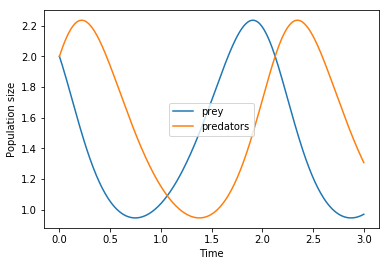

In [39]:
times = model.suggested_times()
parameters = model.suggested_parameters()
print(parameters)

plt.figure()
plt.xlabel('Time')
plt.ylabel('Population size')
plt.plot(times, model.simulate(parameters, times))
plt.legend(['prey', 'predators'])
plt.show()

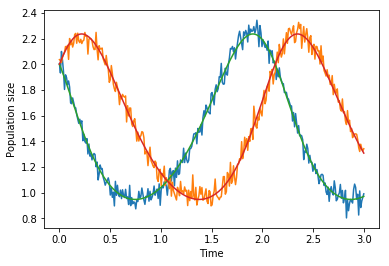

In [40]:
model.set_initial_conditions([2, 2])
values = model.simulate(parameters, times)
sigma = 0.05
noisy_values = values + np.random.normal(0, sigma, values.shape)

plt.figure()
plt.xlabel('Time')
plt.ylabel('Population size')
plt.plot(times, noisy_values)
plt.plot(times, values)
plt.show()

In [41]:
# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, noisy_values)

# Create a log posterior
log_prior = pints.UniformLogPrior([1, 1, 1, 1], [6, 6, 6, 6])
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, sigma)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Run MCMC on the noisy data
x0 = [[4, 1, 2, 3]]*3
mcmc = pints.MCMCController(log_posterior, 3, x0, method = pints.SliceStepoutMCMC)
mcmc.set_max_iterations(2000)
mcmc.set_log_interval(200)

for sampler in mcmc.samplers():
    sampler.set_prob_overrelaxed(0.95)

print('Running')
chains = mcmc.run()
print('Done!')

Running
Using Slice Sampling - Stepout
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     480     0:00.4
2     834     0:00.8
3     1194    0:01.3
200   54317   0:53.9
400   104141   1:38.7
600   153925   2:23.6
800   203392   3:07.6
1000  252770   3:49.4
1200  302287   4:30.4
1400  351782   5:12.5
1600  400968   5:57.2
1800  449929   6:39.3
2000  499145   7:20.3
Halting: Maximum number of iterations (2000) reached.
Done!


R-hat:
[0.9998403343282897, 1.0006273837039843, 1.000608678883754, 1.0005453767519898]


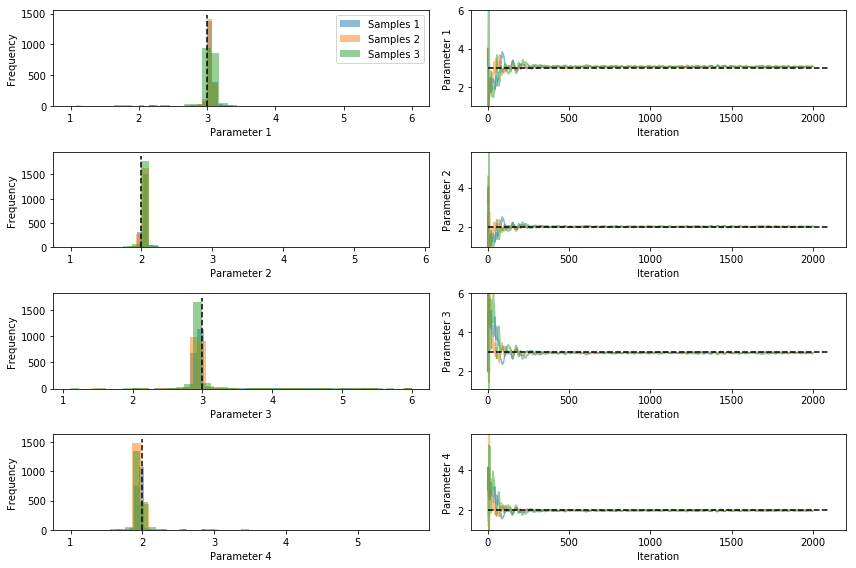

In [42]:
# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

import pints.plot
pints.plot.trace(chains, ref_parameters=parameters)
plt.show()

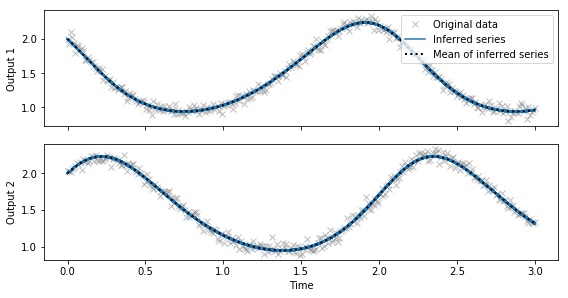

In [43]:
# Select first chain
chain1 = chains[0]

# Remove burn-in
chain1 = chain1[1000:]

# Plot some predictions with these samples
pints.plot.series(chain1, problem)
plt.show()